In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [71]:
plt.style.use('seaborn-v0_8-darkgrid')

In [72]:
# Downloading the data for 5 Stocks - Apple Inc., Tesla Inc., Microsoft Corporation, Amazon.com Inc., Alphabet Inc.
symbols = ["AAPL", "WMT", "XOM", "JPM", "KO"]

start_p = "2023-01-01"
end_p = "2024-06-30"

data = yf.download(symbols, start = start_p, end = end_p )
data_close = data.loc[:, "Close"]
names = data_close.columns.tolist()

[*********************100%***********************]  5 of 5 completed


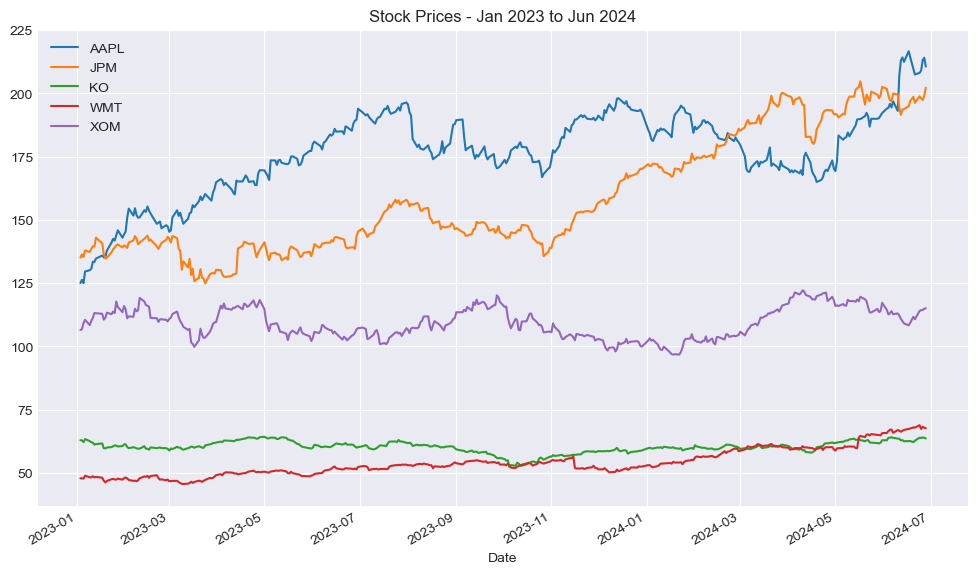

In [73]:
# Plotting historical prices
data_close.plot(figsize=(12,7))
plt.title('Stock Prices - Jan 2023 to Jun 2024')
plt.legend()
plt.show()

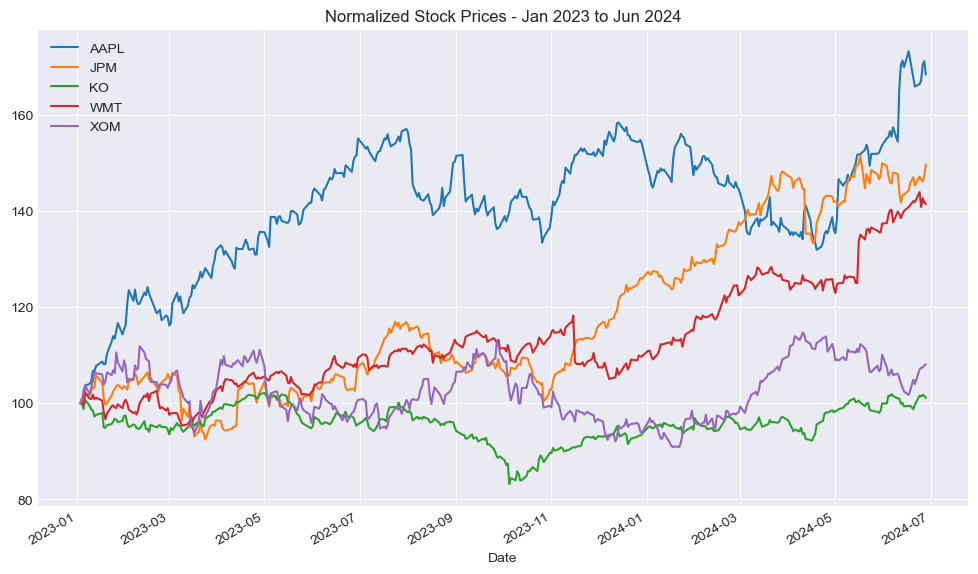

In [74]:
# Normalizing historical prices and plotting updated chart
nprice = data_close / data_close.iloc[0,:] * 100

nprice.plot(figsize=(12,7))
plt.title('Normalized Stock Prices - Jan 2023 to Jun 2024')
plt.legend()
plt.show()

In [75]:
# Estimating the return and covariance

data_ret_d = np.log(data_close).diff().dropna()
data_ret_y = data_ret_d*252
mean = data_ret_y.mean().values
cov = data_ret_d.cov()*252

In [97]:
# Generating 10000 random portfolios

returns_list = []
volat_list = []

for i in range(10000):
    weights = np.random.random(len(names))
    norm_weights = weights / np.sum(weights)
    exp_return = mean.dot(norm_weights)
    returns_list.append(exp_return)
    variance = np.dot(np.dot(norm_weights.T, cov), norm_weights)
    std = np.sqrt(variance)
    volat_list.append(std)

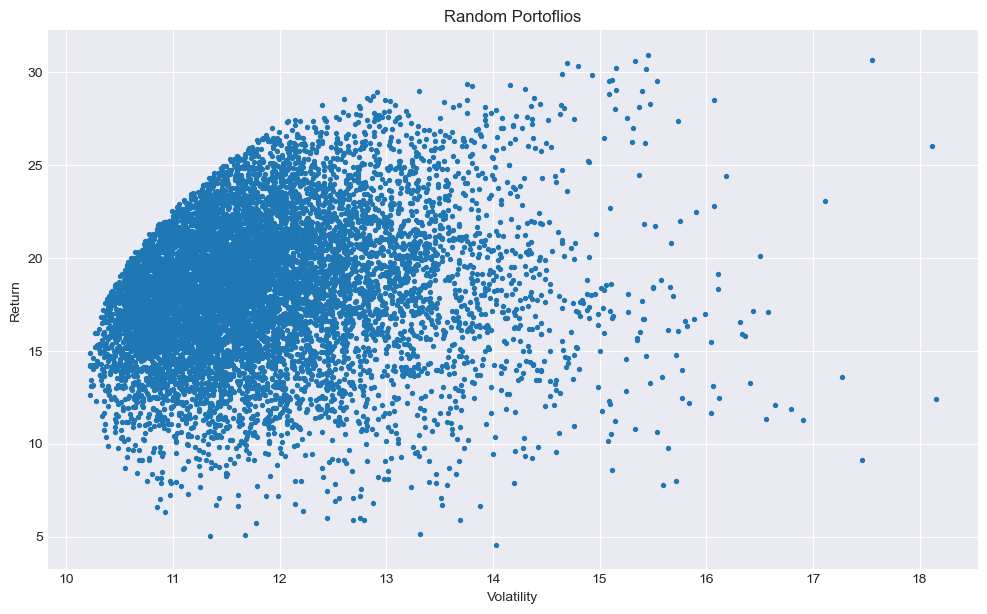

In [99]:
# Plotting the 10000 random portfolios

pfs = pd.DataFrame({'Return': returns_list, 'Volatility': volat_list})*100
pfs.plot(x = 'Volatility', y='Return', kind = 'scatter', s=8, figsize=(12,7))
plt.title('Random Portoflios')
plt.show()

In [78]:
# Mean Variance Optimization

def mean_pf(weights):
    mean = args[0]
    pf_return = mean.dot(weights)
    return pf_return

def std_pf(weights, *args):
    cov = args[1]
    pf_volat = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return pf_volat

lowerbound = 0
upperbound = 1
bounds = tuple ((lowerbound,upperbound) for i in range (len(names)))

weights_starting = np.ones(len(names))/len(names)

args = (data_ret_y.mean(), data_ret_y.cov())
target_return = 0.25

constraints = ({'type':'eq', 'fun': lambda x: mean_pf(x) - target_return}, {'type':'eq', 'fun': lambda x: np.sum(x) - 1})

In [79]:
import scipy.optimize as sco

result_p = sco.minimize(std_pf, weights_starting, args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
weights_p = result_p.x
print([f'{w:.2f}%' for w in weights_p * 100])

['26.80%', '23.14%', '8.67%', '38.61%', '2.78%']


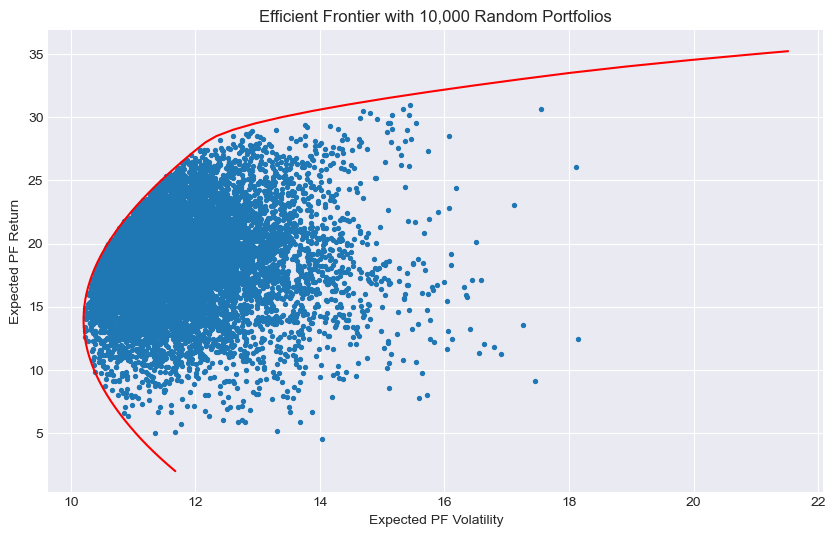

In [107]:
return_ef = []
volat_ef = []

for i in np.arange (0.02, 5, 0.005):
    target_return = i
    constraints = ({'type':'eq', 'fun': lambda x: mean_pf(x) - target_return}, {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    result_ef = sco.minimize(std_pf, weights_starting, args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    weights_optimal = result_ef.x
    ef_exp_return = mean.dot(weights_optimal)
    return_ef.append(ef_exp_return)
    ef_variance = np.dot(np.dot(weights_optimal.T, cov), weights_optimal)
    ef_std = np.sqrt(ef_variance)
    volat_ef.append(ef_std)


ef_portfolio = pd.DataFrame({'Return': return_ef, 'Volatility': volat_ef})*100

plt.figure(figsize=(10, 6))
plt.plot(ef_portfolio.Volatility, ef_portfolio.Return, color = "red")
plt.scatter(pfs.Volatility, pfs.Return, s=8)
plt.title('Efficient Frontier with 10,000 Random Portfolios')
plt.xlabel('Expected PF Volatility')
plt.ylabel('Expected PF Return')
plt.show()